In [1]:
%pip install --force-reinstall "numpy<2" "pandas==2.1.4" "pyarrow<16" "numexpr<2.10"
!pip install xgboost

import os, warnings
warnings.filterwarnings("ignore")

import os, math
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import binomtest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

DATA_DIR = "data"
OUT_DIR = "outputs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

RNG_SEED = 42
np.random.seed(RNG_SEED)

print("Environment ready. XGBoost available:", XGB_AVAILABLE)

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached pandas-2.1.4-cp311-cp311-win_amd64.whl.metadata (18 kB)
  Using cached pyarrow-15.0.2-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached numexpr-2.9.0-cp311-cp311-win_amd64.whl.metadata (8.1 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.1.4-cp311-cp311-win_amd64.whl (10.6 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached pyarrow-15.0.2-cp311-cp311-win_amd64.whl (24.8 MB)
Using cached numexpr-2.9.0-cp311-cp311-win_amd64.whl (96 kB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires python-dateutil==2.8.2, but you have python-dateutil 2.9.0.post0 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.


Environment ready. XGBoost available: True


In [2]:
import pandas as pd, numpy as np
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.1.4
numpy: 1.26.4


In [3]:
CSV_PATH = r"C:\Users\kylek\OneDrive\Desktop\btcusd_1-min_data.csv"

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)
DAILY_CSV = os.path.join(DATA_DIR, "btc_historical_data.csv")

raw_min = pd.read_csv(CSV_PATH)

if  "Timestamp" in raw_min.columns:
    raw_min["Date"] = pd.to_datetime(raw_min["Timestamp"], unit="s", errors="coerce")

colmap = {
    "Open":"Open", "High":"High", "Low":"Low", "Close":"Close", "Volume_(BTC)":"Volume"
}
for k,v in colmap.items():
    if k in raw_min.columns and v not in raw_min.columns:
        raw_min.rename(columns={k:v}, inplace=True)

raw_min = raw_min.dropna(subset=["Date","Open","High","Low","Close"])
raw_min = raw_min.set_index("Date").sort_index()

raw = raw_min.resample("1D").agg({
    "Open":"first",
    "High":"max",
    "Low":"min",
    "Close":"last",
    "Volume":"sum"
}).dropna()

print("Daily rows:", len(raw), "| Range:", raw.index.min().date(), "→", raw.index.max().date())
display(raw.head(), raw.tail())

raw.to_csv(DAILY_CSV)
print(f"Saved daily BTC OHLCV to {DAILY_CSV}")

Daily rows: 5020 | Range: 2012-01-01 → 2025-09-28


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742


,Open,High,Low,Close,Volume
Date,,,,,
2025-09-24,112025.0,114005.0,111115.0,113339.0,1320.906678
2025-09-25,113351.0,113542.0,108652.0,109021.0,2615.572028
2025-09-26,109021.0,110372.0,108676.0,109696.0,1849.109828
2025-09-27,109694.0,109789.0,109130.0,109679.0,475.397198
2025-09-28,109679.0,112375.0,109239.0,112117.0,788.476410


Saved daily BTC OHLCV to data\btc_historical_data.csv


In [4]:
p = pl.from_pandas(raw.reset_index())

p = p.with_columns(
    (pl.col("Close").log().diff()).alias("ret1d")
)

p = p.with_columns(
    (pl.col("ret1d").shift(-1) > 0).cast(pl.Int8).alias("UpTomorrow")
)

def add_lags(tbl, col, ks):
    t = tbl
    for k in ks:
        t = t.with_columns(pl.col(col).shift(k).alias(f"{col}_lag{k}"))
    return t

p = add_lags(p, "ret1d", ks=[1,2,3,5,10,20])

p = p.with_columns([
    (pl.col("High") - pl.col("Low")).alias("HML"),
    (pl.col("Open") - pl.col("Close")).alias("OMC"),
])
p = add_lags(p, "HML", ks=[1,2,3,5])
p = add_lags(p, "OMC", ks=[1,2,3,5])

p = p.with_columns([
    pl.col("ret1d").rolling_mean(window_size=20).alias("ret_ma20"),
    pl.col("ret1d").rolling_std(window_size=20).alias("ret_vol20"),
    pl.col("ret1d").rolling_std(window_size=100).alias("ret_vol100"),
])

p = p.with_columns(
    (pl.col("ret1d") / (pl.col("ret_vol20") + 1e-8)).alias("ret_z20")
)

p = p.with_columns([
    pl.col("ret1d").shift(1).ewm_mean(span=5, ignore_nulls=True).alias("ema5_ret_lag1"),
    pl.col("ret1d").shift(1).ewm_mean(span=20, ignore_nulls=True).alias("ema20_ret_lag1"),
])

p = p.drop_nulls()

drop_cols = {"Date","UpTomorrow","Close","Open","High","Low","Volume"}
feature_cols = [c for c in p.columns if c not in drop_cols]

print("Rows:", p.height, "| Features:", len(feature_cols))
p.head().to_pandas().head()

Rows: 4919 | Features: 23


,Date,Open,High,Low,Close,Volume,ret1d,UpTomorrow,ret1d_lag1,ret1d_lag2,...,OMC_lag1,OMC_lag2,OMC_lag3,OMC_lag5,ret_ma20,ret_vol20,ret_vol100,ret_z20,ema5_ret_lag1,ema20_ret_lag1
0,2012-04-10,4.85,4.87,4.75,4.80,414.817637,-0.010363,1,0.018731,0.012685,...,-0.09,-0.06,0.28,0.01,-0.001639,0.024066,0.060729,-0.430593,0.001804,-0.000582
1,2012-04-11,4.80,4.88,4.78,4.88,262.080348,0.016529,0,-0.010363,0.018731,...,0.05,-0.09,-0.06,-0.08,0.000826,0.023218,0.060663,0.711909,-0.002252,-0.001513
2,2012-04-12,4.88,4.92,4.73,4.86,693.211816,-0.004107,1,0.016529,-0.010363,...,-0.08,0.05,-0.09,0.28,0.000830,0.023218,0.060394,-0.176883,0.004009,0.000205
3,2012-04-13,4.86,4.95,4.81,4.89,1010.845552,0.006154,1,-0.004107,0.016529,...,0.02,-0.08,0.05,-0.06,0.001769,0.023023,0.060166,0.267287,0.001303,-0.000206
4,2012-04-14,4.89,5.01,4.86,4.98,740.638939,0.018238,0,0.006154,-0.004107,...,-0.03,0.02,-0.08,-0.09,0.004625,0.021185,0.058436,0.860883,0.002920,0.000400


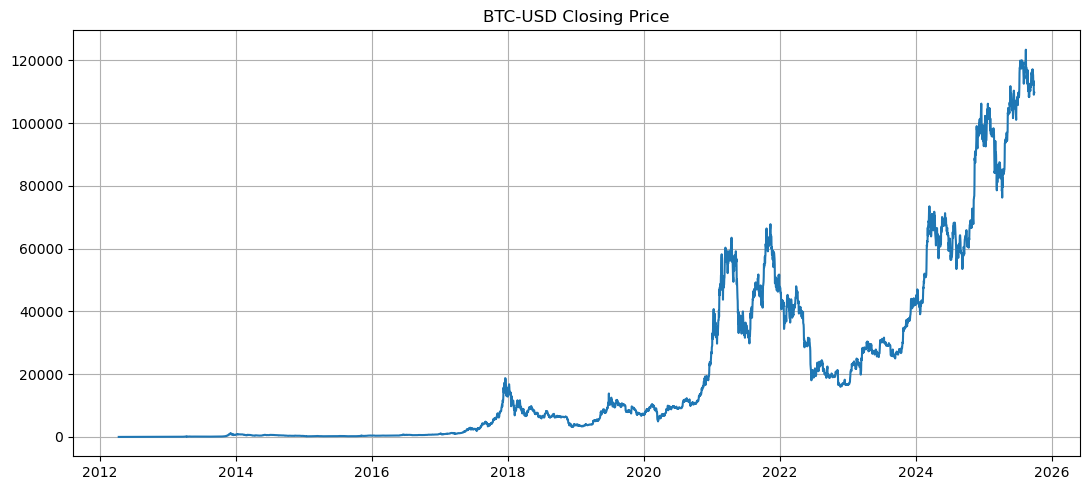

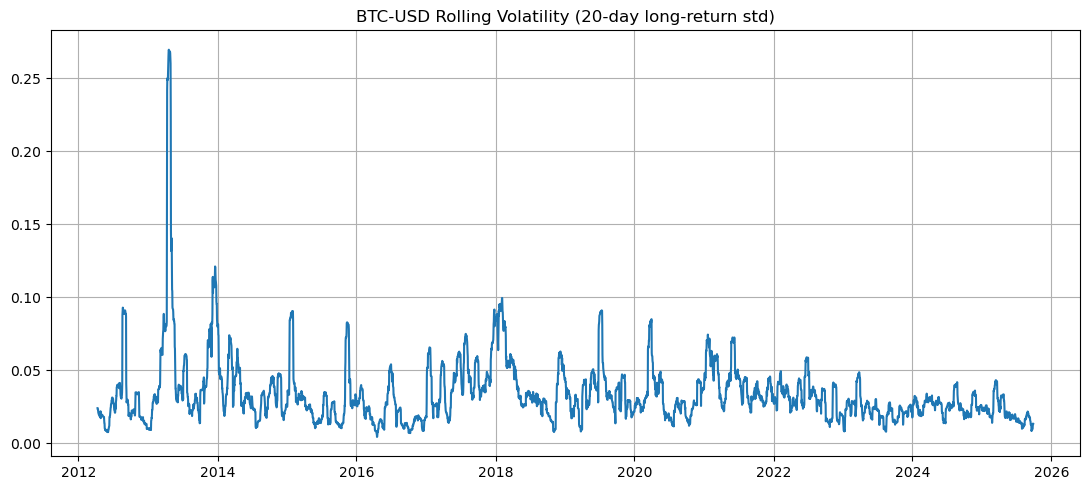

In [5]:
import matplotlib.pyplot as plt
import pandas as pd



OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

dfp = p.select(["Date","Close","ret_vol20"]).to_pandas()
dfp["Date"] = pd.to_datetime(dfp["Date"])

plt.figure(figsize=(11,5))
plt.plot(dfp["Date"], dfp["Close"])
plt.title("BTC-USD Closing Price"); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "btc_price.png")); plt.show()

plt.figure(figsize=(11,5))
plt.plot(dfp["Date"], dfp["ret_vol20"])
plt.title("BTC-USD Rolling Volatility (20-day long-return std)"); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "btc_rolling_vol.png")); plt.show()

In [6]:
def walk_forward_splits(n_rows:int, start_idx:int=750, step:int=30, test_block:int=30):
    splits = []
    for t in range(start_idx, n_rows - test_block, step):
        splits.append((np.arange(0, t), np.arange(t, t + test_block)))
    return splits

In [7]:
def evaluate_walk_forward(
    pframe,
    feature_cols,
    model,
    label_col="UpTomorrow",
    start_idx=750, step=30, test_block=30,
    save_prefix="run",
    use_feature_selection=True,
    k_best=12,
    use_time_decay=False,
    decay_half_life=250,
    tune_threshold=False,
    thr_grid=np.linspace(0.3, 0.7, 41),
):
    X_all = pframe.select(feature_cols).to_pandas().values
    y_all = pframe.select(label_col).to_pandas().values.ravel()
    dates = pd.to_datetime(pframe.select("Date").to_pandas()["Date"])

    def _splits(n_rows, start_idx, step, test_block):
        out = []
        for t in range(start_idx, n_rows - test_block, step):
            out.append((np.arange(0, t), np.arange(t, t + test_block)))
        return out

    splits = _splits(len(pframe), start_idx, step, test_block)

    for i, (tr, te) in enumerate(splits, 1):
        print(
            f"Fold {i:02d}: "
            f"train {dates.iloc[tr[0]]:%Y-%m-%d} → {dates.iloc[tr[-1]]:%Y-%m-%d} | "
            f"test {dates.iloc[tr[0]]:%Y-%m-%d} → {dates.iloc[te[-1]]:%Y-%m-%d} | "
        )

    rows = []
    all_y_true, all_y_pred, all_proba = [], [], []
    feat_scores_sum = np.zeros(len(feature_cols), dtype=float)

    for fold_idx, (tr, te) in enumerate(splits, start=1):

        Xtr = X_all[tr]; Xte = X_all[te]
        ytr = y_all[tr]; yte = y_all[te]

        imputer = SimpleImputer(strategy="median")
        Xtr = imputer.fit_transform(Xtr)
        Xte = imputer.transform(Xte)
        Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
        Xte = np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0)

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)

        selector = None
        if use_feature_selection:
            k = min(k_best, Xtr.shape[1])
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            selector.fit(Xtr, ytr)
            Xtr = selector.transform(Xtr)
            Xte = selector.transform(Xte)

            scores = np.full(len(feature_cols), np.nan)
            scores[:len(selector.scores_)] = selector.scores_
            feat_scores_sum += np.nan_to_num(scores)

        sample_weight = None
        if use_time_decay:
            n = len(ytr)
            lam = math.log(2) / max(1, decay_half_life)
            idx = np.arange(n)
            sample_weight = np.exp(lam * (idx - (n-1)))

        clf = clone(model)
        if sample_weight is not None:
            clf.fit(Xtr, ytr, sample_weight=sample_weight)
        else:
            clf.fit(Xtr, ytr)

        if hasattr(clf, "predict_proba"):
            proba_te = clf.predict_proba(Xte)[:, 1]
        elif hasattr(clf, "decision_function"):
            z = clf.decision_function(Xte)
            proba_te = (z - z.min()) / (z.max() - z.min() + 1e-12)
        else:
            proba_te = clf.predict(Xte).astype(float)

        thr = 0.5
        if tune_threshold and len(ytr) >= 50:
            cut = int(len(ytr) * 0.8)
            Xv, yv = Xtr[cut:], ytr[cut:]
            if hasattr(clf, "predict_proba"):
                pv = clf.predict_proba(Xv)[:, 1]
            elif hasattr(clf, "decision_function"):
                zv = clf.decision_function(Xv)
                pv = (zv - zv.min()) / (zv.max() - zv.min() + 1e-12)
            else:
                pv = clf.predict(Xv).astype(float)
            accs = [accuracy_score(yv, (pv >= t).astype(int)) for t in thr_grid]
            thr = float(thr_grid[int(np.argmax(accs))])

        yhat_te = (proba_te >= thr).astype(int)

        acc = accuracy_score(yte, yhat_te)
        try:
            auc = roc_auc_score(yte, proba_te)
        except ValueError:
            auc = np.nan

        rows.append({
            "fold": fold_idx,
            "asof_date": dates.iloc[te].iloc[-1],
            "acc": acc,
            "auc": auc,
            "thr": thr,
            "n_test": len(te),
        })
        all_y_true.append(yte)
        all_y_pred.append(yhat_te)
        all_proba.append(proba_te)

    res = pd.DataFrame(rows)

    plt.figure(figsize=(11, 4))
    plt.plot(res["asof_date"], res["acc"], label="Accuracy")
    plt.plot(res["asof_date"], res["auc"], label="AUC")
    plt.title(f"Walk-forward performance — {save_prefix}")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"{save_prefix}_wf_perf.png"), dpi=144)
    plt.show()

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)
    proba  = np.concatenate(all_proba)
    res.attrs["y_true"] = y_true
    res.attrs["y_pred"] = y_pred
    res.attrs["proba"]  = proba
    res.attrs["feature_cols"] = feature_cols
    if use_feature_selection:
        res.attrs["mi_scores_sum"] = feat_scores_sum

    k = int((y_true == y_pred).sum())
    n = int(len(y_true))
    acc_overall = k / n
    p_val = binomtest(k, n=n, p=0.5, alternative="greater").pvalue
    z = 1.96
    denom = 1 + z**2/n
    center = acc_overall + z**2/(2*n)
    half = z*np.sqrt((acc_overall*(1-acc_overall)/n) + (z**2/(4*n**2)))
    wilson_low  = (center - half)/denom
    wilson_high = (center + half)/denom
    print(f"[Overall] acc={acc_overall:.3f}, 95% CI [{wilson_low:.3f}, {wilson_high:.3f}], "
          f"one-sided p vs 0.5 = {p_val:.4f}")

    return res


Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-04-10 → 2015-05-24 | 
Fold 14: train 2012-04-10 → 2015-05-24 | test 2012-

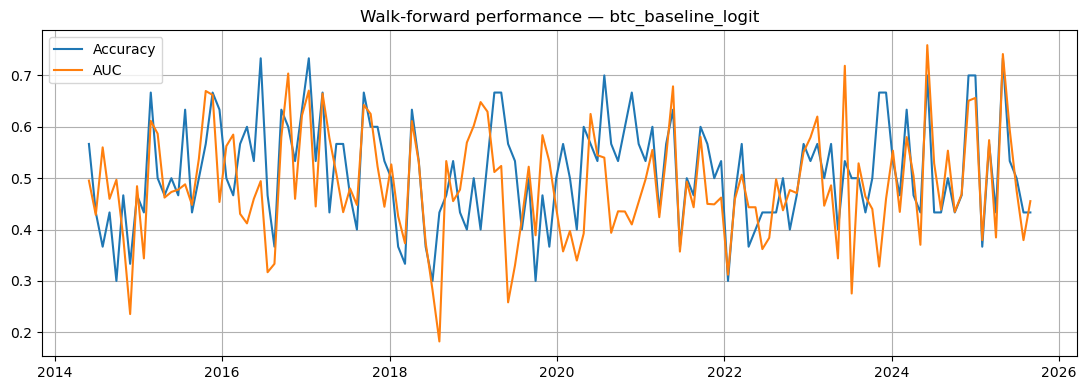

[Overall] acc=0.512, 95% CI [0.497, 0.527], one-sided p vs 0.5 = 0.0658


,fold,asof_date,acc,auc,thr,n_test
133,134,2025-05-01,0.733333,0.741627,0.5,30
134,135,2025-05-31,0.533333,0.593750,0.5,30
135,136,2025-06-30,0.500000,0.475556,0.5,30
136,137,2025-07-30,0.433333,0.379464,0.5,30
137,138,2025-08-29,0.433333,0.455357,0.5,30


In [8]:
logit = LogisticRegression(max_iter=1000, random_state=42)
baseline_results = evaluate_walk_forward(
    pframe=p, feature_cols=feature_cols, model=logit,
    save_prefix="btc_baseline_logit", use_feature_selection=True, k_best=12, use_time_decay=False, tune_threshold=False
)
baseline_results.tail()

Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-04-10 → 2015-05-24 | 
Fold 14: train 2012-04-10 → 2015-05-24 | test 2012-

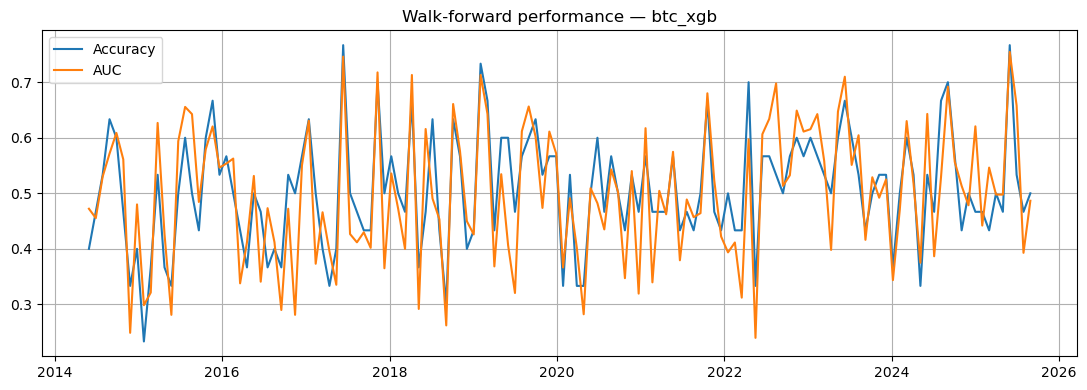

[Overall] acc=0.506, 95% CI [0.490, 0.521], one-sided p vs 0.5 = 0.2422


In [9]:
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
    )

    xgb_results = evaluate_walk_forward(
        pframe=p,
        feature_cols=feature_cols,
        model=xgb,
        save_prefix="btc_xgb",
    )

    xgb_results.tail()

else:
    print("XGBoost isn't available in this kernel (XGB_AVAILABLE=False).")

In [10]:
TRY_FED = True
if TRY_FED:
    from pandas_datareader import data as pdr

    start_str =str(raw.index.min().date())
    fed = pdr.DataReader("FEDFUNDS", "fred", start=start_str)
    fed = fed.rename(columns={"FEDFUNDS": "ff_level"}).asfreq("D").ffill()

    fed_feat = pd.DataFrame(index=fed.index)
    fed_feat["ff_level"] = fed["ff_level"]

    roll=365
    fed_feat["ff_zscore"] = (fed_feat["ff_level"] - fed_feat["ff_level"].rolling(roll).mean()) / \
                            fed_feat["ff_level"].rolling(roll).std()

                             
    fed_feat["ff_trend_90d"] = fed_feat["ff_level"] - fed_feat["ff_level"].shift(90)
    fed_feat["ff_trend_100d"] = fed_feat["ff_level"] - fed_feat["ff_level"].shift(100)

    fed_feat["ff_regime"] = 0
    fed_feat.loc[fed_feat["ff_trend_90d"] > 0.50, "ff_regime"] = 1
    fed_feat.loc[fed_feat["ff_trend_90d"] < -0.50, "ff_regime"] = -1

    rate_change = fed_feat["ff_level"].diff().abs() > 0.01
    grp = rate_change.cumsum()
    fed_feat["days_since_change"] = grp.groupby(grp).cumcount()

    fed_feat["ff_high_rate"] = (fed_feat["ff_level"] > 4.0).astype(int)
    fed_feat["ff_low_rate"] = (fed_feat["ff_level"] < 2.0).astype(int)

    lag_cols = [c for c in fed_feat.columns if c != "ff_level"] + ["ff_level"]
    fed_feat[lag_cols] = fed_feat[lag_cols].shift(1)

    fed_feat = fed_feat.reindex(raw.index).ffill()
    fed_pl = pl.from_pandas(fed_feat.reset_index().rename(columns={"index": "Date"}))

    p = p.join(fed_pl, on="Date", how="left")

    fed_feature_cols = ["ff_level", "ff_zscore", "ff_trend_90d", "ff_trend_180d",
                        "ff_regime", "days_since_change", "ff_high_rate", "ff_low_rate"]
    feature_cols.extend([c for c in fed_feature_cols if c in p.columns])

    for c in [c for c in fed_feature_cols if c in p.columns]:
        p = p.with_columns(pl.col(c).forward_fill())

    print("Fed features added: ", [c for c in fed_feature_cols if c in p.columns])
else:
    print("Skipping Fed Funds aside.")

Fed features added:  ['ff_level', 'ff_zscore', 'ff_trend_90d', 'ff_regime', 'days_since_change', 'ff_high_rate', 'ff_low_rate']


Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-04-10 → 2015-05-24 | 
Fold 14: train 2012-04-10 → 2015-05-24 | test 2012-

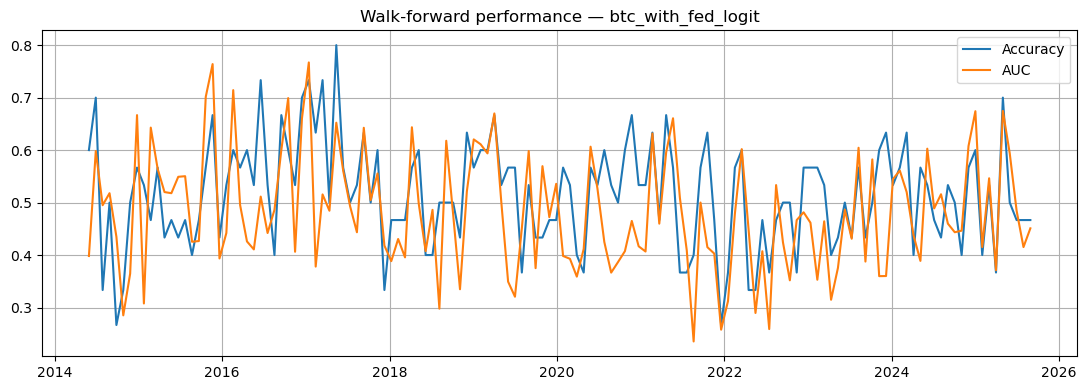

[Overall] acc=0.515, 95% CI [0.500, 0.530], one-sided p vs 0.5 = 0.0280

Fed / Logistic - means ACC: 0.515 | AUC: 0.482
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold

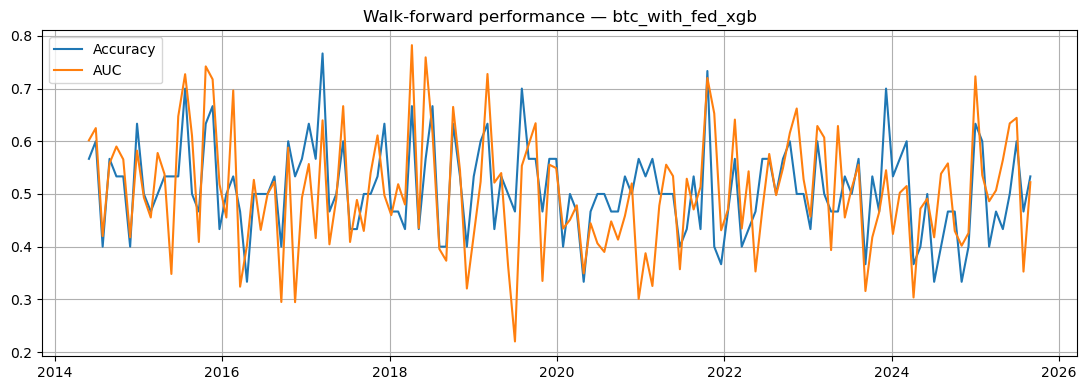

[Overall] acc=0.509, 95% CI [0.494, 0.525], one-sided p vs 0.5 = 0.1157
Fed / XGB     — means ACC: 0.509 | AUC: 0.504

Saved figures:
 - outputs/btc_with_fed_logit_wf_perf.png
 - outputs/btc_with_fed_logit_roc_lastblock.png
 - outputs/btc_with_fed_xgb_wf_perf.png       (if XGB ran)
 - outputs/btc_with_fed_xgb_roc_lastblock.png (if XGB ran)


In [11]:
assert "Date" in p.columns and "UpTomorrow" in p.columns, "Missing Date/UpTomorrow in p."

logit = LogisticRegression(max_iter=1000, random_state=42)

fed_logit_res = evaluate_walk_forward(
    pframe=p,
    feature_cols=feature_cols,
    model=logit,
    save_prefix="btc_with_fed_logit",
    use_feature_selection=True,
    k_best=12,
    use_time_decay=False,
    tune_threshold=False,
)

print("\nFed / Logistic - means",
      "ACC:", round(fed_logit_res["acc"].mean(), 3),
      "| AUC:", round(fed_logit_res["auc"].mean(), 3))

try:
    xgb = XGBClassifier(
        n_estimators=400, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        eval_metrice="auc", random_state=42, n_jobs=-1
    )
    fed_xgb_res = evaluate_walk_forward(
        pframe=p,
        feature_cols=feature_cols,
        model=xgb,
        save_prefix="btc_with_fed_xgb",
        use_feature_selection=True,
        k_best=12,
        use_time_decay=False,
        tune_threshold=False
    )
    print("Fed / XGB     — means",
          "ACC:", round(fed_xgb_res["acc"].mean(), 3),
          "| AUC:", round(fed_xgb_res["auc"].mean(), 3))

except Exception as e:
    print("XGBoost run skipped:", e)

print("\nSaved figures:")
print(" - outputs/btc_with_fed_logit_wf_perf.png")
print(" - outputs/btc_with_fed_logit_roc_lastblock.png")
print(" - outputs/btc_with_fed_xgb_wf_perf.png       (if XGB ran)")
print(" - outputs/btc_with_fed_xgb_roc_lastblock.png (if XGB ran)")


In [12]:
res_obj = fed_logit_res

mi_sum = res_obj.attrs.get("mi_scores_sum", None)
if mi_sum is not None:
    mi_df = pd.DataFrame({"feature": feature_cols, "mi_sum": mi_sum})
    mi_df = mi_df.sort_values("mi_sum", ascending=False)
    print("Top 20 features by cumulative mutual information across folds:\n")
    display(mi_df.head(20))
else:
    print("No MI scores recorded (did you run with use_features_selection=True ?)")
    

Top 20 features by cumulative mutual information across folds:



,feature,mi_sum
19,ret_vol100,2.438943
10,HML_lag2,2.416582
24,ff_zscore,1.680357
1,ret1d_lag1,1.309299
20,ret_z20,1.061909
23,ff_level,0.997930
25,ff_trend_90d,0.862065
11,HML_lag3,0.834723
18,ret_vol20,0.798171
4,ret1d_lag5,0.771833


Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-04-10 → 2015-05-24 | 
Fold 14: train 2012-04-10 → 2015-05-24 | test 2012-

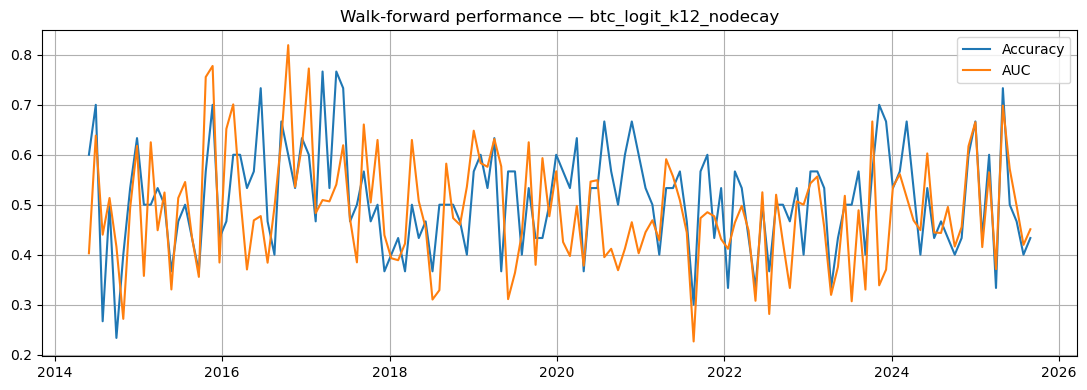

[Overall] acc=0.510, 95% CI [0.495, 0.526], one-sided p vs 0.5 = 0.0932
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

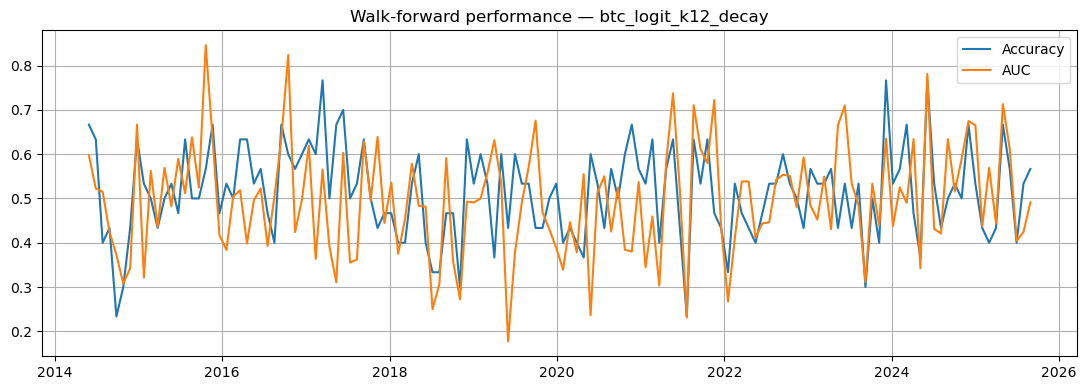

[Overall] acc=0.513, 95% CI [0.498, 0.528], one-sided p vs 0.5 = 0.0513
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

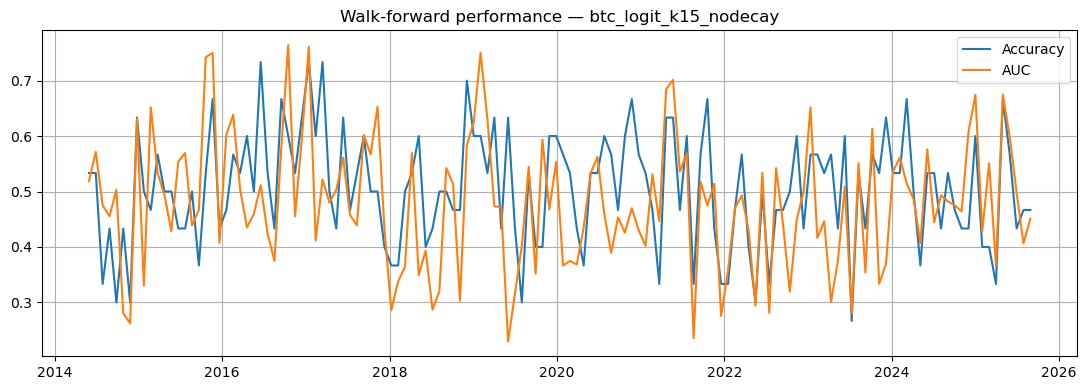

[Overall] acc=0.505, 95% CI [0.490, 0.520], one-sided p vs 0.5 = 0.2620
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

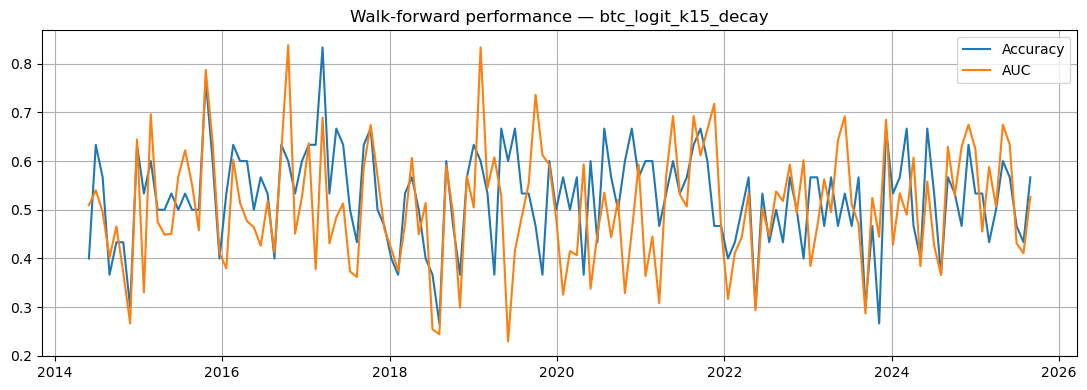

[Overall] acc=0.525, 95% CI [0.509, 0.540], one-sided p vs 0.5 = 0.0008
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

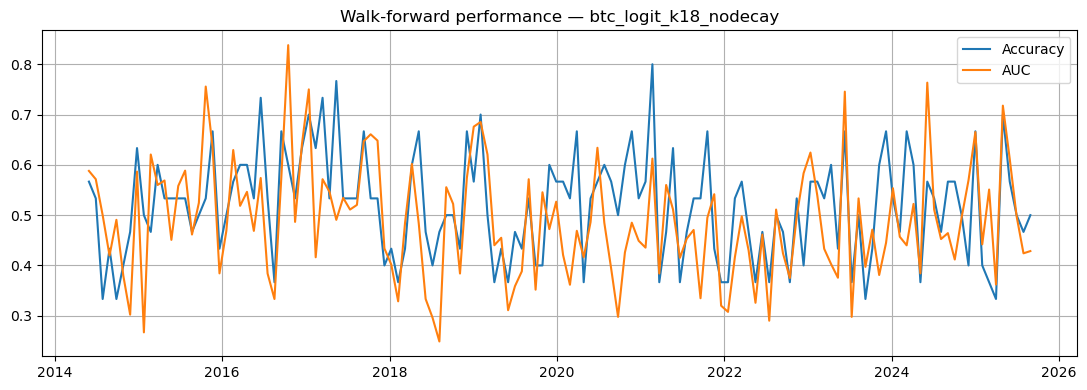

[Overall] acc=0.518, 95% CI [0.503, 0.534], one-sided p vs 0.5 = 0.0095
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

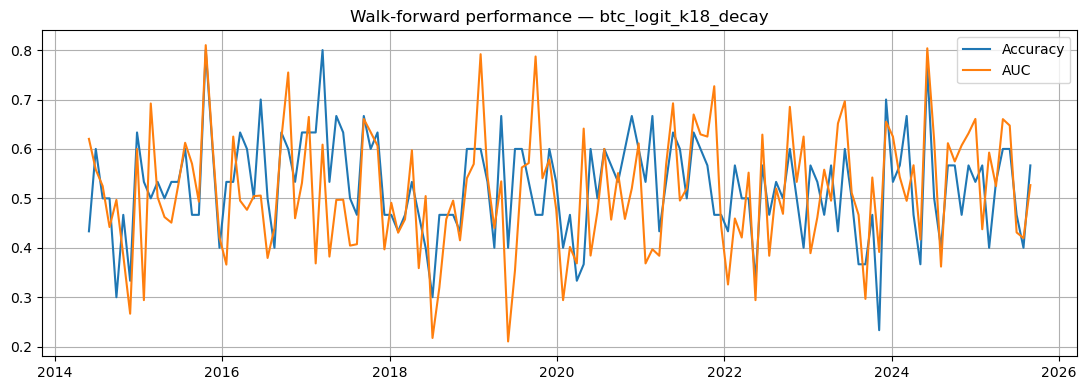

[Overall] acc=0.525, 95% CI [0.510, 0.540], one-sided p vs 0.5 = 0.0007
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

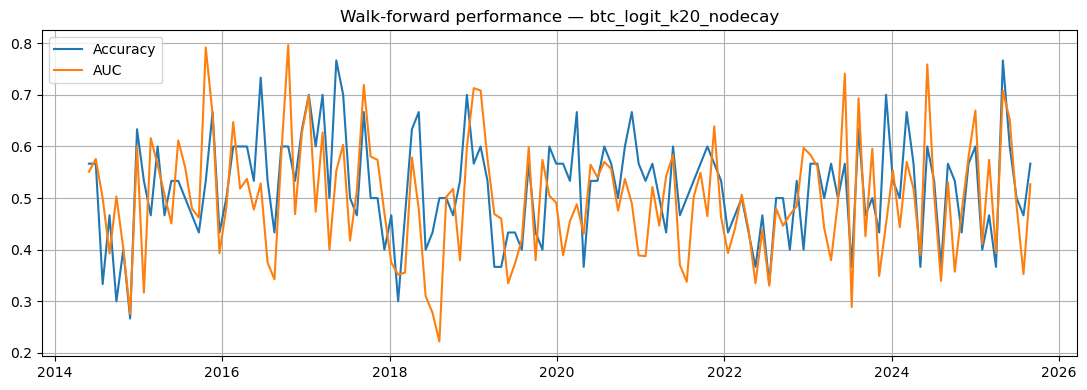

[Overall] acc=0.520, 95% CI [0.504, 0.535], one-sided p vs 0.5 = 0.0062
Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-0

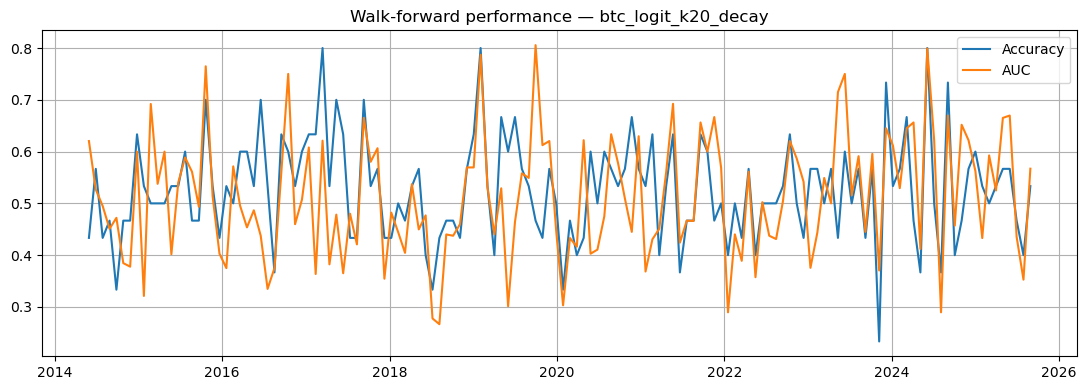

[Overall] acc=0.526, 95% CI [0.511, 0.541], one-sided p vs 0.5 = 0.0004
Walk-forward means (LogReg):


,k_best,time_decay,acc_mean,auc_mean
0,12,False,0.510386,0.487155
2,15,False,0.505072,0.479894
4,18,False,0.518357,0.488207
6,20,False,0.519565,0.497344
1,12,True,0.512802,0.495488
3,15,True,0.524638,0.506331
5,18,True,0.524879,0.513927
7,20,True,0.526087,0.512115


In [13]:
def run_one(k, decay):
    res = evaluate_walk_forward(
        pframe=p, feature_cols=feature_cols,
        model=LogisticRegression(max_iter=1000, random_state=42),
        save_prefix=f"btc_logit_k{k}_{'decay' if decay else 'nodecay'}",
        use_feature_selection=True, k_best=k,
        use_time_decay=decay, tune_threshold=False
    )
    return {
        "k_best": k,
        "time_decay": decay,
        "acc_mean": float(res["acc"].mean()),
        "auc_mean": float(res["auc"].mean()),
    }

grid = []
for k in [12, 15, 18, 20]:
    for decay in [False, True]:
        grid.append(run_one(k, decay))

cmp_df = pd.DataFrame(grid).sort_values(["time_decay","k_best"])
print("Walk-forward means (LogReg):")
display(cmp_df)

Fold 01: train 2012-04-10 → 2014-04-29 | test 2012-04-10 → 2014-05-29 | 
Fold 02: train 2012-04-10 → 2014-05-29 | test 2012-04-10 → 2014-06-28 | 
Fold 03: train 2012-04-10 → 2014-06-28 | test 2012-04-10 → 2014-07-28 | 
Fold 04: train 2012-04-10 → 2014-07-28 | test 2012-04-10 → 2014-08-27 | 
Fold 05: train 2012-04-10 → 2014-08-27 | test 2012-04-10 → 2014-09-26 | 
Fold 06: train 2012-04-10 → 2014-09-26 | test 2012-04-10 → 2014-10-26 | 
Fold 07: train 2012-04-10 → 2014-10-26 | test 2012-04-10 → 2014-11-25 | 
Fold 08: train 2012-04-10 → 2014-11-25 | test 2012-04-10 → 2014-12-25 | 
Fold 09: train 2012-04-10 → 2014-12-25 | test 2012-04-10 → 2015-01-24 | 
Fold 10: train 2012-04-10 → 2015-01-24 | test 2012-04-10 → 2015-02-23 | 
Fold 11: train 2012-04-10 → 2015-02-23 | test 2012-04-10 → 2015-03-25 | 
Fold 12: train 2012-04-10 → 2015-03-25 | test 2012-04-10 → 2015-04-24 | 
Fold 13: train 2012-04-10 → 2015-04-24 | test 2012-04-10 → 2015-05-24 | 
Fold 14: train 2012-04-10 → 2015-05-24 | test 2012-

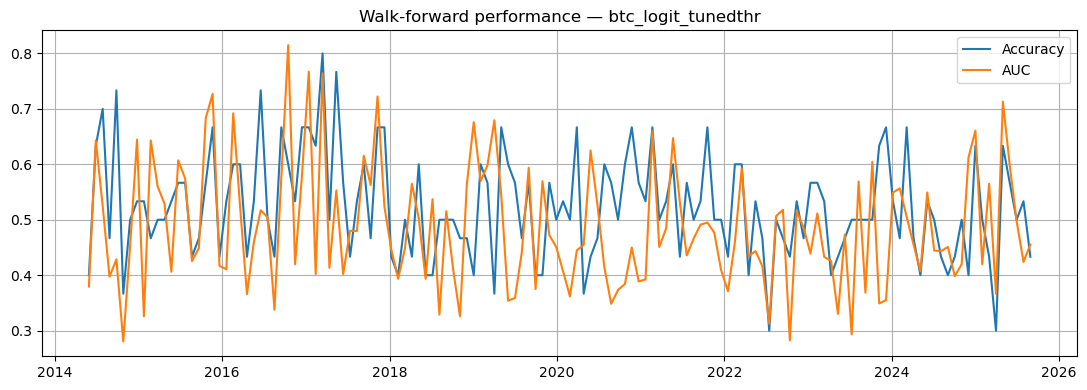

[Overall] acc=0.523, 95% CI [0.508, 0.539], one-sided p vs 0.5 = 0.0013
LogReg tuned-threshold - means ACC: 0.523 | AUC: 0.487


In [14]:
logit_tuned = evaluate_walk_forward(
    pframe=p, feature_cols=feature_cols,
    model=LogisticRegression(max_iter=1000, random_state=42),
    save_prefix="btc_logit_tunedthr",
    use_feature_selection=True, k_best=12,
    use_time_decay=False, tune_threshold=True
)
print("LogReg tuned-threshold - means",
      "ACC:", round(logit_tuned["acc"].mean(), 3),
      "| AUC:", round(logit_tuned["auc"].mean(), 3))

In [15]:
Xdf = p.select(feature_cols).to_pandas()
y = p["UpTomorrow"].to_numpy()
dates = pd.to_datetime(p["Date"].to_pandas())

row_ok = np.isfinite(Xdf).all(axis=1).values
Xdf_ok = Xdf.loc[row_ok].copy()
y_ok = y[row_ok]
dates_ok = dates[row_ok]

last_idx = len(Xdf_ok) -1
X_last = Xdf_ok.iloc[[last_idx]].values
last_date = dates_ok.iloc[last_idx].date()

pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42),
)

pipe.fit(Xdf_ok.values, y_ok)

proba = pipe.predict_proba(X_last)[0, 1]
pred = "UP" if proba >= 0.5 else "DOWN"

print(f"As of {last_date}, model predicts Bitcoin will go {pred} tomorrow (p={proba:.3f})")
    




As of 2025-09-27, model predicts Bitcoin will go UP tomorrow (p=0.560)
